In [1]:
# new model
# 1. 2D Eulerian model (for inert tracer) 
# 2. 1D slab model

# (1) this is very important
# use small enough time step for 1D model, in order to avoid combing slab grid cells, 
# so that there is be less extra fake diffusion induced
# (2)
# change 2D to 1D in later time, to ensure that the plume cross-section is highly skewed,
# make the 1D model model qualified
# (3)
# directly use vertical diffusion in 1D model, which would cause less diffusion in 1D model.


import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

import scipy
from scipy import interpolate
from scipy.sparse import diags
import scipy.sparse as sp

import matplotlib.tri as tri
import matplotlib.pyplot as plt

import pandas as pd

from tqdm import tqdm 

PI = math.pi

In [2]:
# input value

# time step
Dt_2d = 10 # [s]
Dt_1d = 0.5  # [s]

# grid resolution
Dx = 200 # [m]
Dy = 20 # [m]

# grid number
Nx = 5000 # 5000 #243 # 483
Ny = 300  #135 # 271

# define diffusion coefficient
Diff_x = 10.0 # [m2 s-1]
Diff_y = 0.15 # [m2 s-1]

# define a fixed wind field
U_shear = 0.002 # [s-1]

# initial total injected mass
Mass = 1.0 # [kg]
AVO  = 6.022e+23

# running time
time2 = 3600*48 # time for 1d model run

center: 2500 150
U.shape: (300, 5000)


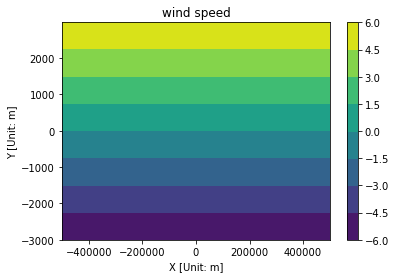

In [3]:
# For high resolution 2D Eulerian model
# for the first 24 hours

Ymax =  Dy*Ny/2
Ymin = -Dy*Ny/2
Xmax =  Dx*Nx/2
Xmin = -Dx*Nx/2


i_init = round(Nx/2)
j_init = round(Ny/2)
print('center:',i_init,j_init)

x = []
for i in range(Nx):
    x.append((i-i_init)*Dx)
    
y = []
for j in range(Ny):
    y.append((j-j_init)*Dy)

X, Y = np.meshgrid(x, y)


V = np.zeros([Ny,Nx]) # [m]
U = np.zeros([Ny,Nx])
print('U.shape:',U.shape)

for j in range(Ny):
    U[j,:] = Y[j,:] * U_shear # [m]
    
plt.contourf(X,Y,U)
plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'wind speed' )
plt.show()


1.0


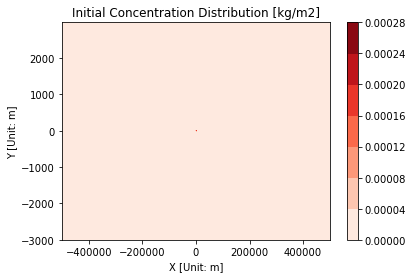

In [4]:
# define initial concentration distribution

Concnt = np.zeros([Ny,Nx])


Concnt[j_init,i_init] = Mass/(Dx*Dy) # [kg m-2]
# Concnt[j_init,i_init] = Concnt[j_init,i_init] / 1.0e+6 / 98.0 * AVO

Original = Concnt[j_init,i_init]*Dx*Dy
print(Original)

contours = plt.contourf(X, Y, Concnt, cmap='Reds')
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2]' )
plt.colorbar()


plt.show()

In [5]:
def Adv_Diff2(C, U, Diff_x, Diff_y, Dt, Dx, Dy, Nx, Ny):
    C_new = C*0.0
    C2    = C*0.0

    i = Nx
    j = Ny
    
    alpha = Dt*U[:,1:Nx-1]/Dx
    C2[:,1:Nx-1] = C[:,1:Nx-1] - 0.5*alpha*(C[:,2:Nx]-C[:,0:Nx-2]) \
                          + 0.5*alpha**2*(C[:,2:Nx]-2*C[:,1:Nx-1]+C[:,0:Nx-2])
      
#     for j in range(0,Ny,1):
#         alpha = Dt*U[j,1]/Dx
#         C2[j,1:Nx-1] = C[j,1:Nx-1] - 0.5*alpha*(C[j,2:Nx]-C[j,0:Nx-2]) \
#                             + 0.5*alpha**2*(C[j,2:Nx]-2*C[j,1:Nx-1]+C[j,0:Nx-2])

    C_new[1:Ny-1,1:Nx-1] = C2[1:Ny-1,1:Nx-1] + \
                             Dt*( Diff_x*(C2[1:Ny-1,0:Nx-2]+C2[1:Ny-1,2:Nx]-2*C2[1:Ny-1,1:Nx-1])/(Dx*Dx) \
                                + Diff_y*(C2[0:Ny-2,1:Nx-1]+C2[2:Ny,1:Nx-1]-2*C2[1:Ny-1,1:Nx-1])/(Dy*Dy) )
    
    return C_new

In [6]:
# The function can calculate the scale length (Xscale, Yscale) 
# of the input concentration distribution (Concnt)

def Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac):
    
    M2d = Concnt*Dx*Dy
    total_mass = np.sum(M2d, axis=(0,1))
    
    Ysum = np.sum(M2d,axis=1) # sum along x axis
    Ysum_sort = sorted(Ysum, reverse=True)
    Ysum_cum = np.cumsum(Ysum_sort)
    numY = abs(Ysum_cum - frac*total_mass).argmin()
    Yscale = numY*Dy
    
    Xsum = np.sum(M2d,axis=0) # sum along x axis
    Xsum_sort = sorted(Xsum, reverse=True)
    Xsum_cum = np.cumsum(Xsum_sort)
    numX = abs(Xsum_cum - frac*total_mass).argmin()
    Xscale = numX*Dx
    
    return Xscale, Yscale

In [7]:
# Test confusion CFL condition

if 2*Diff_y*Dt_2d/(Dy**2)>1:
    print('****************************************')
    print('WARNING: diff Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt_2d')
    print('****************************************')
    
if 2*Diff_x*Dt_2d/(Dx**2)>1:
    print('****************************************')
    print('WARNING: diff X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt_2d/Dx>1:
    print('****************************************')
    print('WARNING: adv X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [8]:
%%time

# time run
Nt           = int(3600*6/Dt_2d)

# Judge_radian = (90-2)/180*PI # [radians]
scale_ratio  = 25

Theta        = 0.0           # [radians]
Height       = 0.0           #[m]
frac = 0.95

for t in tqdm(range(Nt)):    
    Concnt = Adv_Diff2(Concnt, U, Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)
    
    Xscale, Yscale = Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac)
    Theta = math.atan(Xscale/Yscale)
    
    if (t+1)*Dt_2d>3600*2:
        if Xscale/Yscale>scale_ratio:
            print(t*Dt_2d/3600, Xscale, Yscale)
            break    

 91%|█████████ | 1965/2160 [03:00<00:17, 10.87it/s]

5.458333333333333 7200 280
CPU times: user 2min 11s, sys: 50 s, total: 3min 1s
Wall time: 3min


In [9]:
time1 = (t+1)*Dt_2d  # initial time for 1-D grids
time1/3600

5.461111111111111

0 0


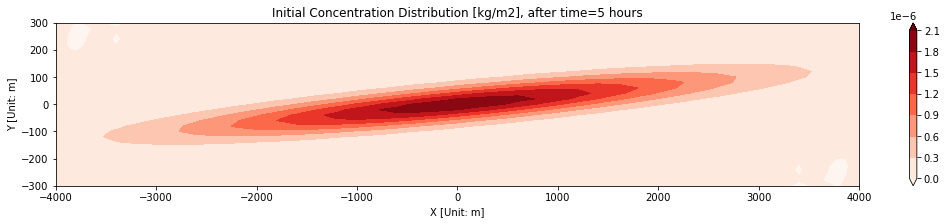

In [10]:
fig, ax = plt.subplots(1, figsize=(18,3))

levs = np.arange(0,24,3)*1e-7
contours = plt.contourf(X, Y, Concnt, levs, cmap='Reds', extend='both')
# contours = plt.contourf(X, Y, Concnt, levs, locator=ticker.LogLocator(), cmap='Reds', extend='max')

# plt.ylim(Ymin, Ymax)
# plt.xlim(Xmin, Xmax)

plt.ylim(-3e2, 3e2)
plt.xlim(-4e3, 4e3)

plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2], after time='+str(int(time1/3600))+' hours' )
print(X[j_init,i_init],Y[j_init,i_init])

plt.show()


In [11]:
#########################################################
#
# 2D to 1D
#
##########################################################

In [12]:
def tilt_C2d_linear(Concnt, x, y, Dx, Dy, Nx, Ny, Theta, Na, Nb, LenA, LenB):
    
    # find the long and short radius given concentration distribution
    # build a 2D nest for integrationn
    Nb_mid = int(Nb/2)

    # interval in long radius
    Adx = LenA*np.sin(Theta)
    Ady = LenA*np.cos(Theta)

    # interval in short radius
    Bdy = LenB*np.sin(Theta)
    Bdx = LenB*np.cos(Theta)

    # define the location in 2D xy mesh used to determine initial concentration
    Y1d = np.zeros((Na,Nb))
    X1d = np.zeros((Na,Nb))

    print('Y1d.shape: ', Y1d.shape)

    # find the location of 1D grid in 2D XY grids
    for i in range(Na):
        X1d[i,Nb_mid] = -Adx*Na/2 + Adx*(i+0.5)   # ???
        Y1d[i,Nb_mid] = -Ady*Na/2 + Ady*(i+0.5)   # ???

    for j in range(Nb_mid+1, Nb, 1):
        X1d[:,j] = X1d[:,j-1] - Bdx
        Y1d[:,j] = Y1d[:,j-1] + Bdy
    
    for j in range(Nb_mid-1, -1, -1):
        X1d[:,j] = X1d[:,j+1] + Bdx
        Y1d[:,j] = Y1d[:,j+1] - Bdy

        
    # set the initial concentration for 1D
    C1d = np.zeros((Na,Nb))

    # Find the correct initial theta for 1D:
    F1       = interpolate.interp2d(x, y, Concnt, kind='linear')

    for i in range(Na):
        for j in range(Nb):
            if( abs(X1d[i,j])<abs(max(x)) or abs(Y1d[i,j])<abs(max(y)) ): # in case the tilt 2-D out ot range
                C1d[i,j] = F1( X1d[i,j], Y1d[i,j] )
        
    return C1d, X1d, Y1d

In [13]:
# calculate the distance between two points:
def Distance_2pts(x1,y1,x2,y2):
    
    Distance = np.sqrt( (x1-x2)**2 + (y1-y2)**2 )
    
    return Distance

In [14]:
# calcualte triangle's area based on its three sides
def Heron_Formula(x1,y1,x2,y2,x3,y3):
    
    L1 = Distance_2pts(x1,y1,x2,y2)
    L2 = Distance_2pts(x1,y1,x3,y3)
    L3 = Distance_2pts(x2,y2,x3,y3)
    
    s = (L1+L2+L3)/2
    
    if L1*L2*L3==0:
        return 0 # the source grid cell point overlaps with the target grid cell point,
                 # which makes the triangle become a segment, overlap area is 0 
    elif (s-L1)*(s-L2)*(s-L3)<=0:
        print("ERROR in Heron_Formula:", L1, L2, L3)
    
    Area = np.sqrt( s*(s-L1)*(s-L2)*(s-L3) )
    
    return Area

In [15]:
# calcualte the intersection point for the two given line
# In this special case:
# (1) the side of the source grid cell must be parallel to either x or y axis
# (2) the side slope of the target grid cell must not be parallel to both x and y axis

def Intersect(target_X1, target_Y1, target_X2, target_Y2, \
              source_X1, source_Y1, source_X2, source_Y2):

    if source_X1==source_X2:
        X_intersect = source_X2
        Y_intersect = (target_Y2-target_Y1)/(target_X2-target_X1)*(X_intersect-target_X1) + target_Y1

    if source_Y1==source_Y2:
        Y_intersect = source_Y2
        X_intersect = (target_X2-target_X1)/(target_Y2-target_Y1)*(Y_intersect-target_Y1) + target_X1
    
    return X_intersect, Y_intersect

In [16]:
#     (a)find a point inside the overlapping area
#     (b) connect inside points to all the seleced edge point of the overlap area
#     (c) find a base select point, to form the base segment with inside point 
#     (d) calculate all the angles, and sort angles to sort the edge ppints

def Sort_points(Points_X, Points_Y):
    
    Xs = Points_X
    Ys = Points_Y
    
    Xs2 = np.array(Points_X)
    Ys2 = np.array(Points_Y)
    
    if len(Xs)>=3:
        X_center = np.mean(Xs)
        Y_center = np.mean(Ys)
        Angles = [0]
                    
        for ip in np.arange(1, len(Xs)):
            Vx1 = Xs[0] - X_center
            Vy1 = Ys[0] - Y_center
                    
            Vx2 = Xs[ip] - X_center
            Vy2 = Ys[ip] - Y_center
                        
            dot = Vx1*Vx2 + Vy1*Vy2      # dot product between [x1, y1] and [x2, y2]
            det = Vx1*Vy2 - Vy1*Vx2      # determinant
            angle = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos), 

            if angle<0: angle = 2*math.pi+angle # from 0 to 2*pi
                            
            Angles.append(angle)
                        
        # sort points from smaller to larger angle
        sort_index = np.argsort(Angles)
        
        Xs2 = Xs2[sort_index]
        Ys2 = Ys2[sort_index]
        
    Xs2 = list(Xs2)
    Ys2 = list(Ys2)
    
    return Xs2, Ys2

In [17]:
z = np.array([10,2,3,4])
index = np.argsort(z)
z = z[index]
len(z)

4

In [18]:
def Delete_same(Points_X, Points_Y):
    Xs = Points_X
    Ys = Points_Y
    
    if len(Xs)>=2:
    
        Xs2 = []
        Ys2 = []
    
        for i in np.arange(0, len(Xs)-1):
            i = int(i)
        
            if Xs[i]!=Xs[i+1] or Ys[i]!=Ys[i+1]:
                Xs2.append(Xs[i])
                Ys2.append(Ys[i])
    
        Xs2.append(Xs[len(Xs)-1])
        Ys2.append(Ys[len(Xs)-1])
        
    else:
        
        Xs2 = Xs
        Ys2 = Ys
    
    return Xs2, Ys2

In [19]:
def In_box(source_X, source_Y, X1d_edge, Y1d_edge):
    Sx = source_X
    Sy = source_Y
    
    Tx = X1d_edge
    Ty = Y1d_edge
    
    sign = []
    
    for i in range(len(Tx)-1):
        Vx1 = Sx - Tx[i]
        Vy1 = Sy - Ty[i]
                    
        Vx2 = Tx[i+1] - Tx[i]
        Vy2 = Ty[i+1] - Ty[i]
                        
        dot = Vx1*Vx2 + Vy1*Vy2      # dot product between [x1, y1] and [x2, y2]
        det = Vx1*Vy2 - Vy1*Vx2      # determinant
        angle = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos), 
        sign.append( angle/abs(angle) )
        
    # for the last segment
    Vx1 = Sx - Tx[3]
    Vy1 = Sy - Ty[3]
                    
    Vx2 = Tx[0] - Tx[3]
    Vy2 = Ty[0] - Ty[3]
                        
    dot = Vx1*Vx2 + Vy1*Vy2      # dot product between [x1, y1] and [x2, y2]
    det = Vx1*Vy2 - Vy1*Vx2      # determinant
    angle = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos), 
    sign.append( angle/abs(angle) )
    
    if np.sum(sign)==4 or np.sum(sign)==-4:
        Is_inside = 1
    else:
        Is_inside = 0
        
    return Is_inside

In [20]:
a = [1,2,2,4,5]
b = [11,22,22,44,55]

aa, bb = Delete_same(a, b)

aa, bb

([1, 2, 4, 5], [11, 22, 44, 55])

In [21]:
def tilt_C2d_conservative(Concnt, x, y, Dx, Dy, Nx, Ny, Theta, Na, Nb, LenA, LenB):
    
    # find the long and short radius given concentration distribution
    # build a 2D nest for integrationn
    Nb_mid = int(Nb/2)
    Na_mid = int(Na/2)

    # interval in long radius
    Adx = LenA*np.sin(Theta)
    Ady = LenA*np.cos(Theta)

    # interval in short radius
    Bdy = LenB*np.sin(Theta)
    Bdx = LenB*np.cos(Theta)

    # define the location in 2D xy mesh used to determine initial concentration
    Y1d = np.zeros((Na,Nb))
    X1d = np.zeros((Na,Nb))

    print('Y1d.shape: ', Y1d.shape)

    # find the location of 1D grid in 2D XY grids
    for i in range(Na):
        X1d[i,Nb_mid] = -Adx*Na/2 + Adx*(i+0.5)   # ???
        Y1d[i,Nb_mid] = -Ady*Na/2 + Ady*(i+0.5)   # ???

    for j in range(Nb_mid+1, Nb, 1):
        X1d[:,j] = X1d[:,j-1] - Bdx
        Y1d[:,j] = Y1d[:,j-1] + Bdy
    
    for j in range(Nb_mid-1, -1, -1):
        X1d[:,j] = X1d[:,j+1] + Bdx
        Y1d[:,j] = Y1d[:,j+1] - Bdy

        
    # set the initial concentration for 1D
    C1d = np.zeros((Na,Nb))
    
    for i in np.arange(1,Na-1):
        for j in np.arange(1,Nb-1):
#     for i in np.arange(Na_mid, Na_mid+1):
#         for j in np.arange(Nb_mid,Nb_mid+1):
            
            i = int(i)
            j = int(j)
            
            X1d_edge = [0,0,0,0]
            Y1d_edge = [0,0,0,0]

            # get the four edge points of the target grid cell: centered at ( X1d[i,j], Y1d[i,j] )
            
            # check the boundary case !!! ???
            
            X1d_edge[0] = (X1d[i,j]+X1d[i-1,j-1])/2
            Y1d_edge[0] = (Y1d[i,j]+Y1d[i-1,j-1])/2
            
            X1d_edge[1] = (X1d[i,j]+X1d[i+1,j-1])/2
            Y1d_edge[1] = (Y1d[i,j]+Y1d[i+1,j-1])/2            

            X1d_edge[2] = (X1d[i,j]+X1d[i+1,j+1])/2
            Y1d_edge[2] = (Y1d[i,j]+Y1d[i+1,j+1])/2            
            
            X1d_edge[3] = (X1d[i,j]+X1d[i-1,j+1])/2
            Y1d_edge[3] = (Y1d[i,j]+Y1d[i-1,j+1])/2
            
            
            # Check whether target grid cell area is equal to Dx*Dy !!!
            Area_target = Heron_Formula(X1d_edge[0], Y1d_edge[0], X1d_edge[2], Y1d_edge[2], \
                                        X1d_edge[1], Y1d_edge[1]) \
                        + Heron_Formula(X1d_edge[0], Y1d_edge[0], X1d_edge[2], Y1d_edge[2], \
                                        X1d_edge[3], Y1d_edge[3])
            
            if i==Na_mid and j==Nb_mid:
                print(f"the target grid cell area is {Area_target}, {Dx*Dy}")
                
#             if abs(Area_target-Dx*Dy)/(Dx*Dy)>1e-3: 
#                 print('ERROR:', int(Area_target), Dx*Dy)
#                 print(X1d_edge[:])
#                 print(Y1d_edge[:])
#                 print(i, j, X1d[i,j], Y1d[i,j])
#                 print( Dx, Distance_2pts(X1d_edge[0], Y1d_edge[0], X1d_edge[1], Y1d_edge[1]) )
#                 print( Dy, Distance_2pts(X1d_edge[2], Y1d_edge[2], X1d_edge[1], Y1d_edge[1]) )
#                 plt.plot(X1d_edge, Y1d_edge, 'r.')
#                 return
            
            # Find all the source grid cells that may overlap with the target grid cell,
            # based on the four edge points of the target
            X_max = np.max(X1d_edge)
            X_min = np.min(X1d_edge)
            Y_max = np.max(Y1d_edge)
            Y_min = np.min(Y1d_edge)
            
            ix_max = np.floor( (X_max - (x[0]-Dx/2)) /Dx )
            ix_min = np.floor( (X_min - (x[0]-Dx/2)) /Dx )
            iy_max = np.floor( (Y_max - (y[0]-Dy/2)) /Dy )
            iy_min = np.floor( (Y_min - (y[0]-Dy/2)) /Dy )
            
            # for the target grid cell located in the edge of the source grid domain
            if ix_min<0: ix_min=0
            if iy_min<0: iy_min=0 
            if ix_max>Nx-1: ix_max=Nx-1
            if iy_max>Ny-1: iy_max=Ny-1
                
            # when the target grid cell is totally outside the source grid domain
            if ix_min>Nx-1: 
                ix_min = Nx-1
                ix_max = Nx-1
                C1d[i,j] = 0
            if iy_min>Ny-1: 
                iy_min = Ny-1
                iy_max = Ny-1
                C1d[i,j] = 0
            if ix_max<0:
                ix_max = 0
                ix_min = 0
                C1d[i,j] = 0
            if iy_max<0: 
                iy_max = 0
                iy_min = 0
                C1d[i,j] = 0
                
            # loop for all selected source grid cells, 
            # calculate the overlap area between the selected soruce grid cell and the target grid cell
            mass = [] # total tracer mass in target grid cell
            area_overlap = [] # overlap area between the target grid cell and source grid cells,
                              # the sum of which should be same as the area of the target grid cell 
            
            for ix in np.arange(ix_min,ix_max+1):
                for iy in np.arange(iy_min,iy_max+1):
                    
                    ix = int(ix)
                    iy = int(iy)
                    
                    # indentify the structure of the overlap area:
                    # how many side/point does this overlap area have?
                    Points_X = [] # save intersection point's X value
                    Points_Y = [] # save intersection points's Y value
                    
                    # four the edge points of the selected source grid cell
                    source_Xedge = [0,0,0,0]
                    source_Yedge = [0,0,0,0]
                    
                    source_Xedge[0] = x[ix]-Dx/2
                    source_Yedge[0] = y[iy]-Dy/2
            
                    source_Xedge[1] = x[ix]-Dx/2
                    source_Yedge[1] = y[iy]+Dy/2            

                    source_Xedge[2] = x[ix]+Dx/2
                    source_Yedge[2] = y[iy]+Dy/2            
            
                    source_Xedge[3] = x[ix]+Dx/2
                    source_Yedge[3] = y[iy]-Dy/2
                    
                    # (1) check whether target grid cell edge points is inside the soruce grid cell:
                    for ip in range(4):
                        if abs(X1d_edge[ip]-x[ix])<Dx/2 and abs(Y1d_edge[ip]-y[iy])<Dy/2:
                            Points_X.append(X1d_edge[ip])
                            Points_Y.append(Y1d_edge[ip])
                                                    
                            
                    # (2) check whether source grid cell edge points are inside the target grid cell:
                    #     by considering the area consistency
                    for ip_S in range(4):
                        
                        Is_inside = In_box(source_Xedge[ip_S], source_Yedge[ip_S], X1d_edge, Y1d_edge)
                        
                        if Is_inside: 
                            Points_X.append(source_Xedge[ip_S])
                            Points_Y.append(source_Yedge[ip_S]) 
                        
#                         Area = 0
#                         for ip in range(3):
#                             Area = Area + Heron_Formula(source_Xedge[ip_S], source_Yedge[ip_S], \
#                                                     X1d_edge[ip], Y1d_edge[ip], X1d_edge[ip+1], Y1d_edge[ip+1])
#                         Area = Area + Heron_Formula(source_Xedge[ip_S], source_Yedge[ip_S], \
#                                                 X1d_edge[0], Y1d_edge[0], X1d_edge[3], Y1d_edge[3])
                        
#                         if abs(Area-Area_target)<1e-10:
#                             Points_X.append(source_Yedge[ip_S])
#                             Points_Y.append(source_Xedge[ip_S]) 
                                            
                        
                        
                    # (3) Check the intersection point between source grid cell side and target grid cell side
                    # first find the intersect points, 
                    # then check whether this intersect point is located inside 
                    # paralell situation would never happen here.
                    for ip in range(4):
                        if ip==3:
                            target_X1 = X1d_edge[ip]
                            target_Y1 = Y1d_edge[ip]
                            target_X2 = X1d_edge[0]
                            target_Y2 = Y1d_edge[0]
                        else:
                            target_X1 = X1d_edge[ip]
                            target_Y1 = Y1d_edge[ip]
                            target_X2 = X1d_edge[ip+1]
                            target_Y2 = Y1d_edge[ip+1]
                            
                        for ip_S in range(4):
                            if ip_S==3:
                                source_X1 = source_Xedge[ip_S]
                                source_Y1 = source_Yedge[ip_S]
                                source_X2 = source_Xedge[0]
                                source_Y2 = source_Yedge[0]
                            else:
                                source_X1 = source_Xedge[ip_S]
                                source_Y1 = source_Yedge[ip_S]
                                source_X2 = source_Xedge[ip_S+1]
                                source_Y2 = source_Yedge[ip_S+1]                            
                        
                            # calculate the intersect point for the two given line 
                            X_intersect, Y_intersect = Intersect(target_X1, target_Y1, target_X2, target_Y2 \
                                                                ,source_X1, source_Y1, source_X2, source_Y2)
                            # check whether this intersect point is located in both the two line segment
                            if (X_intersect-target_X1)*(X_intersect-target_X2)<=0 and \
                               (Y_intersect-target_Y1)*(Y_intersect-target_Y2)<=0 and \
                               (X_intersect-source_X1)*(X_intersect-source_X2)<=0 and \
                               (Y_intersect-source_Y1)*(Y_intersect-source_Y2)<=0:
                                
                                Points_X.append(X_intersect)
                                Points_Y.append(Y_intersect)                                 
                                
                                
                    # finally, we have all the intersection point, let's calculate the overlap area!
                    # Check total aera is equal !!! ???
                    
                    # delete all the totally overlapping points
                    # all the intersection points should be sorted in a fix order !!! ??? 
                    Points_X, Points_Y = Sort_points(Points_X, Points_Y)
                    Points_X, Points_Y = Delete_same(Points_X, Points_Y) # delete the same location points

                    
                    # calculate total overlapping area based on sorted points
                    S_area = 0
                    for ip in np.arange(1,len(Points_X)-1):
                        S_area = S_area + Heron_Formula(Points_X[0], Points_Y[0], \
                                        Points_X[ip], Points_Y[ip], Points_X[ip+1], Points_Y[ip+1])
            
                    mass.append(S_area*Concnt[iy,ix])
                    area_overlap.append(S_area)
                    
                    if i==Na_mid and j==Nb_mid:
                        print("ix, iy: ", ix, iy)
                        print(f"Points_X: {Points_X}")
                        print(f"Points_Y: {Points_Y}")
                        print(f"S_area: {S_area}, {Concnt[iy,ix]}, ")
            
            
            if np.sum(area_overlap)<=0: # the target grid cell is total out of the soruce grid domain
                C1d[i,j] = 0
            else:
                C1d[i,j] = np.sum(mass)/Area_target
            
            if i==Na_mid and j==Nb_mid: print('total area is:', np.sum(area_overlap))
#             if( abs(X1d[i,j])<abs(max(x)) or abs(Y1d[i,j])<abs(max(y)) ): # in case the tilt 2-D out ot range
#                 C1d[i,j] = F1( X1d[i,j], Y1d[i,j] )
        
    return C1d, X1d, Y1d

In [22]:
Concnt.shape

(300, 5000)

In [23]:
# anti-clock-wise

Vx1 = 1
Vy1 = 1

Vx2 = 1
Vy2 = 0

dot = Vx1*Vx2 + Vy1*Vy2      # dot product between [x1, y1] and [x2, y2]
det = Vx1*Vy2 - Vy1*Vx2      # determinant
angle = math.atan2(det, dot)  # atan2(y, x) or atan2(sin, cos), 

if angle<0: angle = 2*math.pi+angle # from 0 to 2*pi

angle/math.pi*180

a = [1,2,3]
np.mean(a)

2.0

In [24]:
# calculate ScaleX and ScaleY containing 99%  of total mass

Xscale, Yscale = Get_XYscale(Concnt, Dx, Dy, Nx, Ny, frac)

Height = Yscale # refernce of the plume cross-section vertical scale for 1D initial
Length = Xscale

Theta = math.atan(Xscale/Yscale)
print(Height, Length, Theta)

math.degrees(math.atan(Xscale/Yscale)), Xscale/Yscale

280 7200 1.531927024616975


(87.77295303258643, 25.714285714285715)

In [25]:
%%time

# 1D grid length
LenB = Dy # number is a arbitraty number
LenA = Dx #
print('rotated 2-D mesh resolution: LenB, LenA: ', LenB, LenA)

# Nb = int(Height/LenB) # short radius
Nb = 2*math.ceil(Ny*Dy/LenB /4)*4

# Nb = Nb*60 # increase grid number in vertical direction

# Na = int(1.5*Length/LenA) # long radius
Na = math.ceil(Nx*Dx/LenA /4)*4
print('rotated 2-D mesh grid number: Nb, Na: ', Nb, Na)

Nb_25  = int(Nb/4)
Nb_mid = Nb_50 = int(Nb/4*2)
Nb_75  = int(Nb/4*3)

Na_25  = int(Na/4)
Na_mid = Na_50 = int(Na/4*2)
Na_75  = int(Na/4*3)

print(" ")
print('Begin remapping:')
# calculate the concentration in rotated 2-D mesh:
C1d, X1d, Y1d = tilt_C2d_conservative(Concnt, x, y, Dx, Dy, Nx, Ny, Theta, Na, Nb, LenA, LenB)

rotated 2-D mesh resolution: LenB, LenA:  20 200
rotated 2-D mesh grid number: Nb, Na:  600 5000
 
Begin remapping:
Y1d.shape:  (5000, 600)
the target grid cell area is 4000.000000000179, 4000
ix, iy:  2500 150
Points_X: [0.3885951548021751, 100.0, 100.0, -0.1943709831795104, -0.3885951548021751]
Points_Y: [-9.992446837770231, -6.118669982679446, 10.0, 10.0, 9.992446837770231]
S_area: 1806.310708099728, 2.0102187720756957e-06, 
ix, iy:  2500 151
Points_X: [100.0, 100.0, -0.1943709831795104]
Points_Y: [10.0, 13.896447760456738, 10.0]
S_area: 195.20106621388993, 1.805122084026846e-06, 
ix, iy:  2501 150
Points_X: [200.23753191021606, 199.76228854248225, 100.0, 100.0]
Points_Y: [-2.2205437417268428, 10.0, 10.0, -6.118669982679446]
S_area: 1417.4225538236265, 1.971694005050659e-06, 
ix, iy:  2501 151
Points_X: [199.4603416006117, 100.0, 100.0, 199.76228854248225]
Points_Y: [17.76434993381362, 13.896447760456738, 10.0, 10.0]
S_area: 581.0656718629423, 1.9072739828480962e-06, 
total area is:

In [26]:
X1d.shape, X.shape

((5000, 600), (300, 5000))

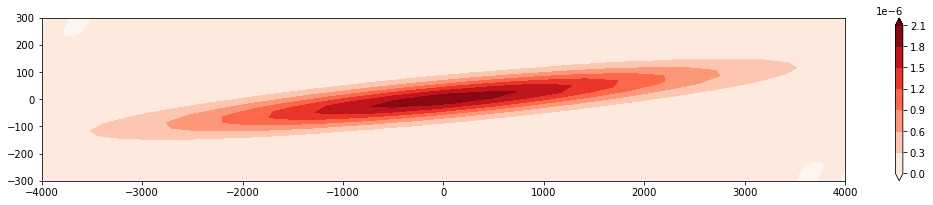

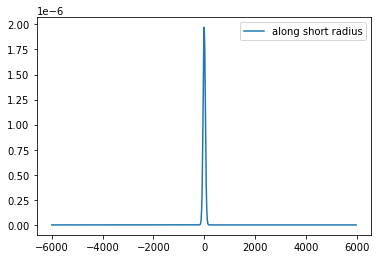

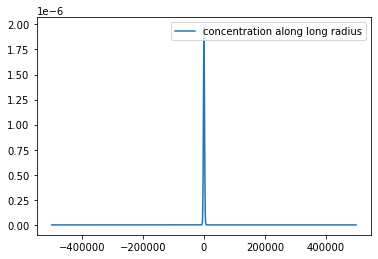

In [27]:
fig, ax = plt.subplots(1, figsize=(18,3))

plt.contourf(X1d, Y1d, C1d, levs, cmap='Reds', extend='both')
# plt.contourf(X1d, Y1d, C1d,  levs, locator=ticker.LogLocator(), cmap='Reds')
plt.colorbar()

# plt.ylim(Ymin, Ymax)
# plt.xlim(Xmin, Xmax)

plt.ylim(-3e2, 3e2)
plt.xlim(-4e3, 4e3)

plt.show()

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*LenB + LenB*i
    
plt.plot(leng-leng[Nb_mid], C1d[Na_mid,:], label='along short radius')
plt.legend()
plt.show()

leng2 = np.zeros(Na)
for i in range(Na):
    leng2[i] = 0.5*LenA + LenA*i
    
plt.plot(leng2-leng2[Na_mid], C1d[:,Nb_mid], label='concentration along long radius')
plt.legend(loc='upper right')
plt.show()


In [28]:
# Calculate the concentration given the La and Lb

# La, Lb = calc_LaLb(C1d, LenA, LenB)

La = Length
Lb = LenB

print(LenA, LenB)
print(La, Lb)


C_box = np.zeros(Nb)
for i in range(Nb):
    C_box[i] = sum(C1d[:,i]) *(LenA*LenB)/ (La*Lb)


200 20
7200 20


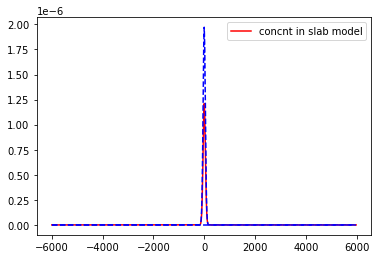

In [29]:
# for the 2nd phase: 1D model

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*LenB + LenB*i
    
plt.plot(leng-leng[Nb_mid], C_box, 'r', label='concnt in slab model')

plt.plot(leng-leng[Nb_mid], C1d[Na_mid,:], 'b--')
plt.plot(leng-leng[Nb_mid], C1d[Na_25,:], 'b--')

plt.legend()
plt.show()

In [30]:
# total mass check

total_mass = np.sum(Concnt, axis=(0,1))*Dx*Dy
Total_m1 = np.sum(C1d, axis=(0,1))*LenA*LenB
mass_1D = np.sum(C_box)*La*Lb

print(total_mass, Total_m1, mass_1D)
print((total_mass-mass_1D)/total_mass)

0.9999999999999998 0.9999999999999967 0.9999999999999969
2.8865798640254078e-15


In [31]:
##################################################################
#
# run 1D
#
##################################################################

In [32]:
# diffusion process
def Difussion2(C, Diff_y, Dt, Dy, Ny):
    C_diff = C*0.0
    
    C_diff[1:Ny-1] = C[1:Ny-1] + Dt*Diff_y*(C[0:Ny-2]+C[2:Ny]-2*C[1:Ny-1])/(Dy*Dy)
    
    return C_diff

In [33]:
%%time

print('Theta origin:',Theta)


Nt = int(time2/Dt_1d)

Diff_v = Diff_y
Diff_h = Diff_x

for it in np.arange(1,Nt+1,1): 
    # shear effect:
    S = La*Lb
    Theta_old = Theta
    Theta = np.arctan( np.tan(Theta) + U_shear*Dt_1d )
    La = La * (np.tan(Theta)**2+1)**0.5 / (np.tan(Theta_old)**2+1)**0.5
#     La = La * (1 + U_shear**2 *Dt_1d**2 *np.cos(Theta)**2 + 2*U_shear*Dt_1d*np.sin(Theta)*np.cos(Theta) )**0.5
    Lb = S/La
    
    Theta1 = (Theta+Theta_old)/2
    Diff_b = Diff_v*np.sin(Theta1) # + Diff_h*np.cos(Theta1)
    Diff_a = Diff_v*np.cos(Theta1) + Diff_h*np.sin(Theta1)
    
    # Test confusion CFL condition
    if 2*Diff_b*Dt_1d/(Lb**2)>1:
        print('****************************************')
        print('WARNING: diff Y: CFL condition is not satisfied')
        print('Combing grid to incease Dy')
        print('****************************************')
        
        print('time for combing slab (hours):', it*Dt_1d/3600, 'hour', 'Lb:', Lb)
        
        Lb = 2*Lb
        C_new = C_box*0.0
        for i in range(Nb_50):
            C_box[i] = 0.5* ( C_box[2*i]+C_box[2*i+1] )
        C_new[Nb_25-1:Nb_75-1] = C_box[0:Nb_50]
        C_box = C_new    
        
    
    # diffusion effect in short radius
    C_box = Difussion2(C_box, Diff_b, Dt_1d, Lb, Nb)
        
    # diffusion effect in long radius:
#     La_old = La
#     La = np.sqrt(La_old**2+2.0*Diff_a*Dt_1d)
#     C_box = C_box *La_old /La

    if it*Dt_1d%600==0:
        df = pd.DataFrame(C_box)
        df.to_csv('Concnt_1d_'+str(int(it*Dt_1d/600))+'_10min.txt', index = False)
        
        df1 = pd.DataFrame([Lb,La])
        df1.to_csv('Lb_'+str(int(it*Dt_1d/600))+'_10min.txt', index = False)       
    
    
    # divide plume cross-section into 5 segments once the cross-section is highly distorted
#    Judge_L = 2*110*1000 # [m]
#    if La>Judge_L:
print('Theta finish:',Theta)

Theta origin: 1.531927024616975
Theta finish: 1.5681031969562862
CPU times: user 12.4 s, sys: 334 ms, total: 12.8 s
Wall time: 15.1 s


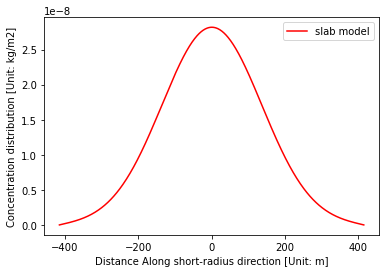

Original:  1.0
mass in 2D:  0.9999999999999998
mass in 1D:  0.9953652398283097


In [34]:
# plot

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*Lb + Lb*i

plt.plot(leng-Lb*Nb_50, C_box,'r',label='slab model')

#plt.ylim(0, 14)

plt.xlabel('Distance Along short-radius direction [Unit: m]')
plt.ylabel('Concentration distribution [Unit: kg/m2]')
plt.legend()
plt.show()


print('Original: ', Original)
print('mass in 2D: ', np.sum(Concnt, axis=(0,1))*Dx*Dy)
print('mass in 1D: ', np.sum(C_box)*La*Lb)

In [35]:
###############################################################################################################
#
# run 2-D for comparison
#
###############################################################################################################

In [36]:
# Test confusion CFL condition

if 2*Diff_y*Dt_2d/(Dy**2)>1:
    print('****************************************')
    print('WARNING: diff Y: CFL condition is not satisfied')
    print('Try to increase Dy or decrease Dt_2d')
    print('****************************************')
    
if 2*Diff_x*Dt_2d/(Dx**2)>1:
    print('****************************************')
    print('WARNING: diff X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')
    
# Test advective CFL condition
if np.max(U)*Dt_2d/Dx>1:
    print('****************************************')
    print('WARNING: adv X: CFL condition is not satisfied')
    print('Try to increase Dx or decrease Dt_2d')
    print('****************************************')

    contours = plt.contourf(X,Y,Concnt)
#    plt.clabel(contours, inline=True, fontsize=8)
    plt.show()

In [ ]:
%%time

# for validation: Gaussian analytical results Vs. 1D slab model.

print('time1=', time1/3600, '(h); time2', time2/3600, 'h')
t_total = time1+time2

Concnt2 = Concnt

# time run
Nt           = int(time2/Dt_2d)

print(Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)

for t in tqdm(np.arange(1,Nt+1,1)):
    Concnt2 = Adv_Diff2(Concnt2, U, Diff_x, Diff_y, Dt_2d, Dx, Dy, Nx, Ny)

  0%|          | 0/17280 [00:00<?, ?it/s]

time1= 5.461111111111111 (h); time2 48.0 h
10.0 0.15 10 200 20 5000 300


 25%|██▌       | 4355/17280 [06:24<19:39, 10.96it/s]

In [ ]:
contours = plt.contourf(X, Y, Concnt2, levs, locator=ticker.LogLocator(), cmap='Reds')



plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)

plt.colorbar()
plt.xlabel('X [Unit: m]')
plt.ylabel('Y [Unit: m]')
plt.title( 'Initial Concentration Distribution [kg/m2], after time='+str(t_total)+'s' )
print(X[j_init-1:j_init+2,i_init-1:i_init+2],Y[j_init-1:j_init+2,i_init-1:i_init+2], \
      Concnt2[j_init-1:j_init+2,i_init-1:i_init+2])
print(X[j_init,i_init],Y[j_init,i_init], Concnt2[j_init,i_init])
plt.show()

In [ ]:
# calculate ScaleX and ScaleY containing 99%  of total mass

Xscale2, Yscale2 = Get_XYscale(Concnt2, Dx, Dy, Nx, Ny, frac)

Height2 = Lb*Nb # Yscale2 # refernce of the plume cross-section vertical scale for 1D initial
Length2 = Xscale2

Theta2 = math.atan(Xscale2/Yscale2)
print(Height2, Length2, Theta2)
print('Theta & Theta2', Theta, Theta2)
math.degrees(math.atan(Xscale2/Yscale2))

In [ ]:
%%time

# 1D grid length

# LenB doesn't have big influence on final results
LenB2 = Lb # Dy # number is a arbitraty number
LenA2 = Dx # Dx*1.5 # Dx
print('LenB, LenA: ', LenB2, LenA2)

Nb2 = int(Height2/LenB2) # short radius
Nb2 = math.ceil(Nb2/4)*4

Na2 = Nx # int(Length2/Dx) # Nx # long radius
Na2 = math.ceil(Na2/4)*4
print('Nb, Na: ', Nb2, Na2)

Nb2_25  = int(Nb2/4)
Nb2_mid = Nb2_50 = int(Nb2/4*2)
Nb2_75  = int(Nb2/4*3)

Na2_25  = int(Na2/4)
Na2_mid = Na2_50 = int(Na2/4*2)
Na2_75  = int(Na2/4*3)


C1d2, X1d2, Y1d2 = tilt_C2d_conservative(Concnt2, x, y, Dx, Dy, Nx, Ny, Theta2, Na2, Nb2, LenA2, LenB2)

plt.contourf(X1d2, Y1d2, C1d2, cmap='Reds')

plt.colorbar()

plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)
plt.show()





leng2 = np.zeros(Nb2)
for i in range(Nb2):
    leng2[i] = 0.5*LenB2 + LenB2*i
print('leng2.shape:', leng2.shape)
print('C1d2.shape:', C1d2.shape)   

plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_mid,:], label='along short radius')
plt.legend()
plt.show()




leng2 = np.zeros(Na2)
for i in range(Na2):
    leng2[i] = 0.5*LenA2 + LenA2*i
    
plt.plot(leng2-leng2[Na2_mid], C1d2[:,Nb2_mid])
plt.title('concentration along long radius')
plt.show()


In [ ]:
# Calculate the concentration given the La and Lb

#La2, Lb2 = calc_LaLb(C1d2, LenA2, LenB2)

La2 = La # Length2
Lb2 = Lb

#La2 = La # #######################################  important  #####

print(LenA2, LenB2)
print(La2, Lb2)

C_box2 = np.zeros(Nb2)
C_box2_Asum = np.zeros(Nb2)

for i in range(Nb2):
    C_box2[i] = sum(C1d2[:,i]) *(LenA2*LenB2)/ (La2*Lb2)
    C_box2_Asum[i] = sum(C1d2[:,i]) *(LenA2*LenB2)
    

In [ ]:
print('Original: ', Original)
print('mass in 2D: ', np.sum(Concnt, axis=(0,1))*Dx*Dy)
print('mass in 1D: ', np.sum(C_box)*La*Lb)
print('mass in 2D again: ', np.sum(Concnt2, axis=(0,1))*Dx*Dy)
print('mass in 2D_to_1D for comparison:', np.sum(C_box2)*La2*Lb2)
print('mass in tilting 2D:', np.sum(C1d2, axis=(0,1))*LenA2*LenB2)
Lb2, LenB2, La2, LenA2

In [ ]:
# for the 2nd phase: 1D model


leng2 = np.zeros(Nb2)
for i in range(Nb2):
    leng2[i] = 0.5*LenB2 + LenB2*i
    
plt.plot(leng2-leng2[Nb2_mid], C_box2, 'r', label='concnt2 in slab model')

plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_mid,:], 'y--')
plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_75,:], 'g--')
plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_25,:], 'b--')

plt.legend()
plt.show()

# ??? red line ???

In [ ]:
# for the 2nd phase: 1D model


leng2 = np.zeros(Nb2)
for i in range(Nb2):
    leng2[i] = 0.5*LenB2 + LenB2*i
    
plt.plot(leng2-leng2[Nb2_mid], C_box2_Asum, 'r', label='concnt2 in slab model')

plt.plot(leng2-leng2[Nb2_mid], (LenA2*LenB2)*np.sum(C1d2[:,:], axis=0), 'y--')
# plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_75,:], 'g--')
# plt.plot(leng2-leng2[Nb2_mid], C1d2[Na2_25,:], 'b--')

plt.legend()
plt.show()


In [ ]:
# plot

leng = np.zeros(Nb)
for i in range(Nb):
    leng[i] = 0.5*Lb + Lb*i
    

# plot
fig = plt.figure(figsize=(5,3), dpi=300)
ax = fig.add_subplot()

Num = 5

ax.plot(leng[2+Num:Nb-Num]-leng[Nb_mid], C_box[2+Num:Nb-Num],'b',label='1-D cross-sectional grid')
ax.plot(leng[2+Num:Nb-Num]-leng[Nb_mid], C_box2[2+Num:Nb-Num], 'r--', label='2-D cross-sectional grid') # ???
# ax[0].plot(0*leng2,C_box2, 'k--')

ax.plot(0, max(C_box), 'ks')
ax.plot(0, max(C_box2), 'ks')


# ax.set_title(f'(a)', loc='left')
ax.set_ylabel('Concentration [$kg \cdot m^{-2}$]', fontsize=12)
ax.set_xlabel('Distance [m]', fontsize=12)

# tick_locs = [0, 1e5,2e5, 3e5, 4e5, 5e5]
# tick_lbls = ['0', '1e5', '2e5', '3e5', '4e5', '5e5']
# ax.set_yticks(np.array(tick_locs))
# ax.set_yticklabels(tick_lbls,fontsize=11)

ax.tick_params(axis='x', labelsize=11)  # to Set Matplotlib Tick Labels Font Size
ax.tick_params(axis='y', labelsize=11)

# ax[0].set_xlim(-1000,1000)
ax.legend()

print( (max(C_box) - max(C_box2))/ max(C_box2) )
print(max(C_box) , max(C_box2))
print(Height, Length)
print(Height2, Length2)